# Assignment 6 Ian Feekes

The contents of this notebook mark the work done for Assignment 6 of USD MSAAI's Image Processing course done by Ian Feekes. 

If the work done here does not meet expectations or requirements, please contact me at ifeekes@sandiego.edu 9163339381 and I will gratefully and expediently make necessary fixes. 

Thank you for taking the time to evaluate my work and for the gift of feedback!

## Part 1- Digit generator

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### a) Reading data

From Keras, import the mnist dataset. We need to reshape the images and normalize them.

In [ ]:
#a- Reading data
import tensorflow as tf
#Load the mnist dataset from tf.keras
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1] by deducting 127.5 and dividing to 127.5
train_images = (train_images - 127.5) / (127.5)
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### b) Generator Model

We can now create our generator model. We use Conv2DTranspose (upsampling) layers to produce the
image from seed (Generator part). Call this generator model without training just to see what happens
when we import a noise to a model.

In [ ]:
# Creating the generative model function
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

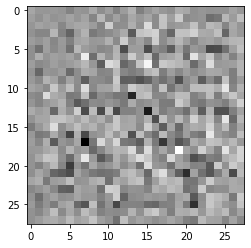

In [ ]:
# Use the generator model which is not trained yet to create an image
generator = make_generator_model()

noise = tf.random.normal([1, 100])  #This creates the noise
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#### Generator Model Analysis: What is this image?

The above image is simply the output of the untrained generator model when fed the noise vector from the call 
``` noise = tf.random.normal(1, 100])``` 

We know this image matches the output dimensions specified by the output ayer of the above generator model.

```    assert model.output_shape == (None, 28, 28, 1)```

The goal of the generator model above is to generate realistic-looking images that would fool the discriminator. From two cells above with the 
``` make_generator_model()```
call we can see that the model has a 7 x 7 x 256 unit node input layer. This layer is followed bya batch normalization layer 

```    model.add(layers.BatchNormalization())```

This is followed immediately by a Rectified Linear Unit activation function 

```    model.add(layers.LeakyReLU()) ```

This layer feeds into three convolutional layers (with strides) which also use batch normalization and ReLu until using tanh for the final layer, as employed by the first proposal for successful Deep Convolutional GAN. 

The strides are employed so that the generator can learn its own upsampling, rather than losing dimensionality and becoming deterministic through the pooling operation. 

Batch normalization is used to reduce the vanishing gradient problem with bad randomized input fed into the generator, along with the mode collapse problem (wherein the generator will only generate a single image or small subset of images rather than the full training data). Training stability is lost when batch normalization is applied to the output layer, which is why it's only done with the first four layers.

### c) Create Discriminator Model

Now, create a discriminator model using Keras. Like what we did above, apply this discriminative model
on top of the above, generate an image, and see the result. Maybe looking at the output does not reveal
enough information. Instead, we can apply a cross entropy function to compare the output with the real
one.

In [ ]:
#c- Create discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
# Applying discriminative model on the untrained image which was the output of generative model
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00222855]], shape=(1, 1), dtype=float32)


In [ ]:
train_dataset

<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

### d) Compute Loss Functions

We need to create two loss functions.
- Discriminator loss: This method quantifies how well the discriminator can distinguish real images from
fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's
predictions on fake (generated) images to an array of 0s.
- Generator loss: The generator's loss quantifies how well it was able to trick the discriminator. Intuitively.
If the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we
will compare the discriminator’s decisions on the generated images to an array of 1s.

In [ ]:
#d- Compute the loss
# Discriminator loss This method quantifies how well the discriminator is able to distinguish real images from fakes.
# It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
#Generator loss The generator's loss quantifies how well it was able to trick the discriminator. 
#Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### e) Model Design

Now, it is time fortraining the model. It is recommended to take a checkpoint on the model. The training
loop begins with the generator receiving a random seed as input. That seed is used to produce an image.
The discriminator is then used to classify real images (drawn from the training set) and fake images
(produced by the generator). The loss is calculated for each of these models, and the gradients are used
to update the generator and discriminator. There is a function provided for you to train the model and
save the image.

2
You can call the train function with two elements: train_dataset and number of epochs. The model takes
a while to train but saving checkpoints allows us to get back to model whenever it is needed. While the
model is loading, pay attention to the changes in epochs and results. After training, take a checkpoint and
save the model. I recommend downloading the model on your Google drive or a local machine. This helps
not to re-train the model next time that you need to retrieve the model.
I also provided a code to save the steps of changes as a gif file.

In [ ]:
%mkdir /content/training_checkpoints

In [ ]:
# e- Model design
# Let's save the model for future references
checkpoint_dir = '/content/training_checkpoints'
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Image_Processing/ASG6/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Model parametrs
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. 
#The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). 
#The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    print("after generator gradients")
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    i = 0
    for image_batch in dataset:
      train_step(image_batch)
      i = i + 1
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

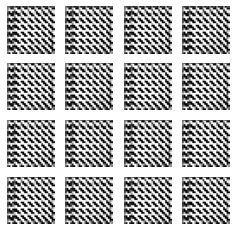

In [ ]:
#Call the function in proper way
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# You can use these commands to save the evpolution as a GIF file
anim_file = 'GAN_digit.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
%ls
%pwd

drive/                   image_at_epoch_0017.png  image_at_epoch_0035.png
GAN_digit.gif            image_at_epoch_0018.png  image_at_epoch_0036.png
image_at_epoch_0001.png  image_at_epoch_0019.png  image_at_epoch_0037.png
image_at_epoch_0002.png  image_at_epoch_0020.png  image_at_epoch_0038.png
image_at_epoch_0003.png  image_at_epoch_0021.png  image_at_epoch_0039.png
image_at_epoch_0004.png  image_at_epoch_0022.png  image_at_epoch_0040.png
image_at_epoch_0005.png  image_at_epoch_0023.png  image_at_epoch_0041.png
image_at_epoch_0006.png  image_at_epoch_0024.png  image_at_epoch_0042.png
image_at_epoch_0007.png  image_at_epoch_0025.png  image_at_epoch_0043.png
image_at_epoch_0008.png  image_at_epoch_0026.png  image_at_epoch_0044.png
image_at_epoch_0009.png  image_at_epoch_0027.png  image_at_epoch_0045.png
image_at_epoch_0010.png  image_at_epoch_0028.png  image_at_epoch_0046.png
image_at_epoch_0011.png  image_at_epoch_0029.png  image_at_epoch_0047.png
image_at_epoch_0012.png  image_at_epoc

'/content'

In [ ]:
%cp GAN_digit.gif '/content/drive/MyDrive/Colab Notebooks/Image_Processing/ASG6/images'

#### What is your Understanding from this GIF file?

The cell above just looks in the current directory and takes all png images and throws them into GAN_digit.gif. So this GIF contains the evolution of the generators output from being fed random noise 16 times immediately after a training epoch ```seed = tf.random.normal([num_examples_to_generate, noise_dim])``` through the 50 epochs. 

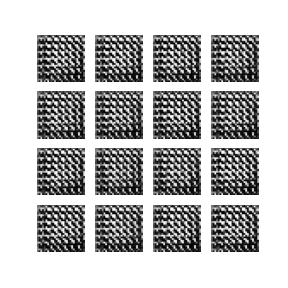

While the changes in the gif are subtle, they are certainly noticable. The generator has loss punished by the success of the discriminator.

This means that with more time given, the output of this image may eventually represent much more closely, the digits characteristic of the dataset.

# Part 2- Pokemon characters and GAN

In [ ]:
#Install d2l package
!pip install d2l==1.0.0-alpha1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 121 kB 67.5 MB/s 
     |████████████████████████████████| 1.6 MB 53.8 MB/s 
     |████████████████████████████████| 83 kB 3.0 MB/s 


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [ ]:
#a- Read the dataset and store it
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

# We store the directory in this variable
data_dir = d2l.download_extract('pokemon')
batch_size = 256
# Use preprocessing from Keras to read images from directory using given batch size and map them to 64x64 images
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [ ]:
#Normalize the data between [-1,1]
# We normalize the data with  0.5  mean and  0.5  standard deviation to match the value range
# Write a function to normalize the images by dividing them to 255 and use gaussian normalization with mean of 0.5 and standard deviation of 0.5.
def transform_func(X):
    X = X / 255.
    X = (X - 0.5) / (0.5)
    return X


data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

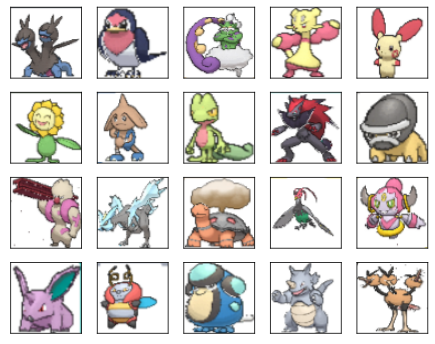

In [ ]:
#b- Visualize first 20 images
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

## The Generator

The generator needs to map the noise variable to a RGB image with width and height to be $64\times 64$ . 

In [ ]:
#c- Creating the generator
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

#### Explain your understanding of the G_block here

The generator's basic block is given a class called ```G_block``` described by the cell above. 

Each of these blocks contains a convolutional layer with strides, with batch normalizational and rectified linear unit activation function. 

This follows the guidelines put out by Goodfellow et. all when they first created a successful convolutional GANs, wherein for the Deep Convolutional Generator, multiple G_blocks could be used by the generator to create the high quality output.

This G_block allows the generator to map the input of a G_block series of layers to a 64 X 64 shape as seen by the snippet of code below. 

In [ ]:
x = tf.zeros((2, 16, 16, 3))  # Input based on the instruction
#Call the G_block package and use 20 as the number of layers (input of the class)
g_blk = G_block(20)
# Show the dimension of the output
g_blk(x).shape

TensorShape([2, 32, 32, 20])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [ ]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

In [ ]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

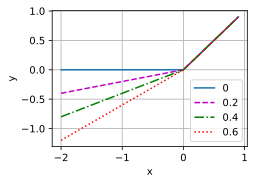

In [ ]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block

In [ ]:
# d- Block of Discriminator
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

#### Explain your understanding of D_block

The discriminator's basic block is given a class called ```D_block``` described by the cell above. Configurations of this basic block will describe every layer of the descriminator with the exception of the convolutional output layer.

Each of these blocks contains a convolutional layer with strides (which in this case is 2 both ways).
 ```        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)``` 

This is followed by a batch normalizational layer.

 ```        self.batch_norm = tf.keras.layers.BatchNormalization()```

Leaky ReLU activation function is used for all of these blocks, but the last layer in the descriminator does not have an activation function.

```        self.activation = tf.keras.layers.LeakyReLU(alpha)```


This follows the guidelines put out by Goodfellow et. all when they first created a successful convolutional GANs, wherein for the Deep Convolutional Generator, multiple D_blocks could be used by the descriminator to scrutinize the generators' high quality output.

In [ ]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
d_blk = D_block(20)
# Show the dimension of the output
d_blk(x).shape


TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.


In [ ]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

In [ ]:
#It uses a convolution layer with output channel  1  as the last layer to obtain a single prediction value.
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training




In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"lr": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')

#### Explain your understanding from this model here

This model is a Deep Convolutional Generative Adversarial Network, which should have superior image quality to the conventional GANs. 

The model has the same general structure as conventional GANs in that it has a Generator trying to mimick training data, and a Descriminator trying to determine which data is generated and which is real, wherein the two networks in this adversarial pattern, learn from each other and improve.

The Generator ```net_G``` is made up of ```G_block``` structures (explained above) with a convolutional output layer which has a tanh activation function.

The Discriminator ```net_D``` is made up of ```D_block``` structures (also explained above).

loss_D 0.000, loss_G 11.338, 698.2 examples/sec on /GPU:0


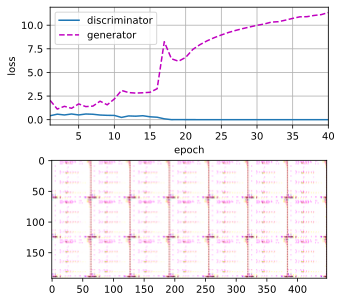

In [ ]:
#We train the model with a small number of epochs just for demonstration. For better performance, the variable num_epochs can be set to a larger number.
latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

#### What is your understanding from this learning curve?

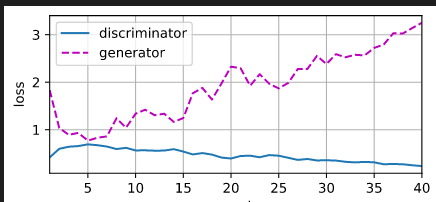

The above learning curve shows the loss of both the descriminator ```net_D``` in blue and the generator ```net_G``` in pink as a function of training epochs.

We know that the loss of the descriminator, ```loss_D``` is similar to the value obtained by part 1 in being the cumulative binary cross entropy of its predictions for both the real image and the generated image.

The loss of the generator, ```loss_G``` is also similar to the value obtained by part 1 - simply a binary crossentropy from being able to fool the discriminator. 

We see from the learning curve that initially for the first 2 epochs, the loss of the generator dips down as it fools the discriminator, which in turns actually sees a small increase in loss. This may be simply from a fluke of having a relatively un-trained discriminator making poor guesses. 

fter about 5 epochs, the discriminator sees fewer losses while the generator starts a steady climb upwards in loss, most likely from the discriminator's ability to predict with strong accuracy.

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
%shell jupyter nbconvert --to pdf '/content/drive/MyDrive/Colab Notebooks/Image_Processing/ASG6/Assignment6.ipynb'